## Roadmap
- load the raw data
- perform basic analysis
- define customer churn problem
- features extraction/engineering
- model training (Neural network with automatic tuning for hyperparameters using **auto_design** module)
- performance validation
- next steps

In [43]:
# code imports
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import f1_score
from auto_design.utils import design
from sklearn.model_selection import train_test_split

In [23]:
# load the data and perform basic analysis
raw_data = pd.read_csv('./resources/raw_data.csv')
print('number of players = {}'.format(len(set(raw_data.device))))
print('number of records = {}'.format(len(raw_data)))
raw_data.head(5)

number of players = 25957
number of records = 153929


,device,score,time
0,352610060979119,7,1421157320
1,352610060979119,0,1421157288
2,352610060979119,6,1421157344
3,99000072289368,106,1421163166
4,357470044931974,278,1421163783


#### Data frame explanation: 

- device: unique ID per each player 
- score: score that the player got during this session 
- time: the number of seconds passed since epoch. For Unix system, January 1, 1970, 00:00:00 at UTC is epoch (the point where time begins). 

#### Customer churn definition 

In this demo customer churn is defined as the probability of a **new** player leaving the game for an (x) amount of days after playing for a (y) amount of days. The observation period shall be referred to from now on as (op) while the churn period shall be referred to as (cp). While the player may start playing the game again after the (cp), given a large enough (cp) it is highly unlikely especially in a casual game. Also, a proper (cp) can be determined by performing simple analysis on the available game logs. For more details about the definition of observation period, churn period and new players churn please refer back to the [research article](https://doi.org/10.1371/journal.pone.0180735)    

In [24]:
# define function used to construct features
def construct_data(raw_data, op, cp, exist=False):
    '''
    Parameters
    ----------
    raw_data : DataFrame
        the raw data to construct training features from
    op : int
        the length of opservation period in days
    cp : int
        the length of churn period in days

    Returns
    -------
    output : DataFrame
        a dataframe for the training data along with it's output.
    '''
    if exist:
        with open('./resources/construct_data.p', 'rb') as file:
            output = pickle.load(file)
            return output
    output_list = list()
    # convert op/cp into seconds
    op = int(op*24*60*60) 
    cp = int(cp*24*60*60)
    # clean the raw_data frame
    raw_data.dropna(inplace=True)
    # extract players list
    players = list(set(raw_data['device']))
    # build features vector for each player
    for player in players:
        # extract player logs and calculate relative time
        log = raw_data[raw_data['device']==player]
        log = log.sort_values(by='time', ascending=True, ignore_index=True) # sort by time
        t0 = log['time'].iloc[0]
        log['time'] = log['time'].apply(lambda x: x-t0) # calculate relative time
        log_op = log[log['time']<=op]
        # build features
        active_duration = log_op['time'].iloc[-1]
        play_count = len(log_op)
        best_score = log_op['score'].max()
        worst_score = log_op['score'].min()
        mean_score = log_op['score'].mean()
        best_score_index = (1/play_count)*log_op['score'].argmax()
        best_sub_mean_count = (best_score-mean_score)/play_count if play_count!=0 else np.nan
        best_sub_mean_ratio = (best_score-mean_score)/mean_score if mean_score!=0 else np.nan
        sd_score = np.std(log_op['score'])
        # build target
        target = int(not(len(log[(log['time']>op) & (log['time']<=(op+cp))])>0)) # 1 for churn 0 for not
        # construct feature vector
        output_list.append({'active_duration':active_duration,
                            'play_count':play_count,
                            'best_score':best_score,
                            'worst_score':worst_score,
                            'mean_score':mean_score,
                            'best_score_index':best_score_index,
                            'best_sub_mean_count':best_sub_mean_count,
                            'best_sub_mean_ratio':best_sub_mean_ratio,
                            'sd_score':sd_score,
                            'target':target})
    # construct return dataframe
    output = pd.DataFrame(data=output_list)
    output.dropna(inplace=True)
    output.reset_index(inplace=True, drop=True)
    # save copy in resources to save time
    with open('./resources/construct_data.p', 'wb') as file:
        pickle.dump(output, file)
    # final return
    return output

In [25]:
# construct the features for the raw_data that will be used during the training
op = 1 
cp = 15
output = construct_data(raw_data, op, cp, exist=True) # exist flag loads a chached version of the features

output.describe()

,active_duration,play_count,best_score,worst_score,mean_score,best_score_index,best_sub_mean_count,best_sub_mean_ratio,sd_score,target
count,25653.000000,25653.000000,25653.000000,25653.000000,25653.000000,25653.000000,25653.000000,25653.000000,25653.000000,25653.000000
mean,6816.589950,3.450630,326.534362,173.294780,234.480301,0.199692,23.317557,0.535754,60.687720,0.835419
std,19388.204449,7.857417,664.225656,455.410912,492.531553,0.282005,87.854676,0.832059,201.129590,0.370809
min,0.000000,1.000000,1.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,42.000000,7.000000,30.500000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,14.000000,2.000000,124.000000,35.000000,83.000000,0.000000,0.444444,0.028571,1.000000,1.000000
75%,224.000000,3.000000,322.000000,138.000000,220.500000,0.500000,15.750000,0.863636,48.256260,1.000000
max,86399.000000,545.000000,20964.000000,20964.000000,20964.000000,0.989362,4077.555556,16.625216,8649.801706,1.000000


We have 9 features to predict one target. It should be noted that the data is biased towards class 1 (churn). Hence as a performance metric F1 score instead of accuracy is used. As for loss function [Binary focal loss function](https://towardsdatascience.com/demystifying-focal-loss-i-a-more-focused-version-of-cross-entropy-loss-f49e4b044213) is used. It should also be noted that other measurements could have been taken such as changing the data sample.  

Since we have 25653 training records. Using deep neural networks will be avoided as well, as most probably it will overfit. However, with more training data Deep feed forward nets, 1D CNN or LSTM may be tested out on the raw (op) vector instead of trying to manually create the features. 

For the actual training of the model **auto_design** is used, which is a custom-made module that builds full machine learning pipelines covering: 

1. Data pre-processing 

2. Feature engineering using autoencoders 

3. Hyperparameters tuning using genetic algorithms 

For now, this module is restricted to feed forward neural nets but nothing stops it from expanding to any other machine learning models and feature engineering stages. 

In [26]:
# prepare the training data
features = ['active_duration', 'play_count', 'best_score',
            'worst_score', 'mean_score', 'best_score_index',
            'best_sub_mean_count', 'best_sub_mean_ratio',
            'sd_score']
x, y = np.array(output[features]).astype(np.float64), np.array(output[['target']]).astype(np.float64)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=int(len(x)*0.1))

In [29]:
# specify problem type
problem_type = 'classification'
# specify the size of population and number of generations
size_population = 5
number_generations = 5
# design ML pipeline using auto_design module
ml_design, log = design(x_train,
                        y_train,
                        problem_type, 
                        size_population, 
                        number_generations)

91/91 [==============================] - 0s 52us/step
gen	nevals	avg    	min    	max    
0  	5     	1.60986	1.49607	1.67414
91/91 [==============================] - 0s 104us/step
1  	2     	1.49341	1.46769	1.51117
91/91 [==============================] - 0s 254us/step
2  	4     	1.55851	1.46769	1.6759 
91/91 [==============================] - 0s 363us/step
3  	4     	1.52202	1.46769	1.63724
91/91 [==============================] - 0s 458us/step
4  	5     	1.63933	1.53349	1.78574
91/91 [==============================] - 0s 63us/step
5  	4     	1.57741	1.41796	1.8343 


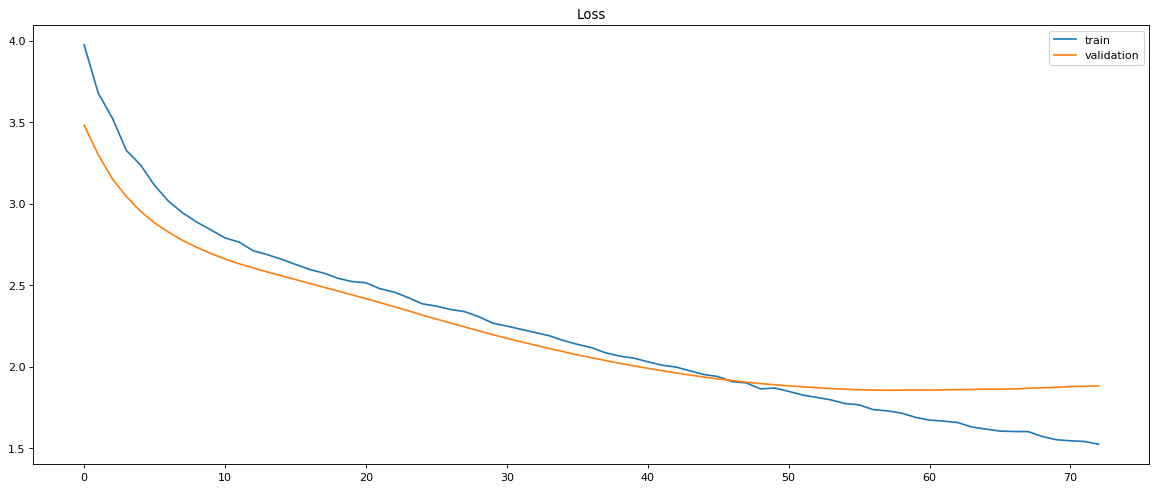

In [34]:
# visualize loss curves for best found model
history = ml_design['model'].history
pyplot.figure(figsize=(18, 16), dpi= 80, facecolor='w')
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend() 

After a certain number of epochs, the validation loss may start to increase again this is where the early stopping condition is used.

In [39]:
# generate the predection for the test sample
scaler = ml_design['scaler']
encoder = ml_design['encoder']
model = ml_design['model']
x_test = scaler.transform(x_test)
x_test = x_test if encoder==None else encoder.predict(x_test)
y_pred = model.predict(x_test)

In [60]:
# calculate the F1 score
f1_score_0 = f1_score(y_test, y_pred.round(), pos_label=0, average='binary')
print('F1 score for class 0 = {}'.format(round(f1_score_0, 3)))
f1_score_1 = f1_score(y_test, y_pred.round(), pos_label=1, average='binary')
print('F1 score for class 1 = {}'.format(round(f1_score_1, 3)))

F1 score for class 0 = 0.907
F1 score for class 1 = 0.72
